# GENERADOR_PALETA (version equivalente del codigo de blender en collab )


Todo el código que hemos desarrollado se centra en la extracción y visualización de paletas de colores dominantes de imágenes utilizando el algoritmo K-Means, una técnica fundamental del aprendizaje no supervisado. Esto se alinea directamente con cómo generador_paleta funciona en Blender, ya que K-Means agrupa automáticamente los píxeles de una imagen en clústeres basados en su similitud de color, sin necesidad de etiquetas previas. Nuestro flujo de trabajo comienza con una interfaz de configuración de parámetros interactiva, implementada con ipywidgets, que permite ajustar dinámicamente el número de colores deseados, el factor de reescalado para el procesamiento y la tolerancia para la unicidad de los colores resultantes. Tras el procesamiento, el sistema no solo visualiza la imagen original y su paleta de colores extraída, sino que también ofrece una visualización 3D interactiva de la distribución de píxeles en el espacio de color RGB, mostrando cómo K-Means agrupa estos puntos y posiciona los centroides (los colores dominantes de la paleta). Finalmente, para evaluar la calidad de este agrupamiento no supervisado, incluimos una serie de diagramas de siluetas para diferentes números de clústeres (K), proporcionando una métrica cuantitativa y una visualización de cuán compactos y bien separados están los clústeres de color, y ofreciendo una interpretación clara sobre la idoneidad de la selección de K en términos de la asignación de píxeles y la distinción entre los colores de la paleta.

In [11]:
# @title 1. Instalar Librerías y Preparar Entorno
# -----------------------------------------------------------------------------
# 1. Instalar Librerías y Preparar Entorno
# -----------------------------------------------------------------------------
!pip install Pillow scikit-learn matplotlib seaborn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Para visualización 3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import io
import requests
import seaborn as sns
from sklearn.metrics import silhouette_score, silhouette_samples

print("Librerías instaladas y cargadas.")

# Función para cargar una imagen desde una URL o archivo (para Colab)
def load_image_for_colab(image_source):
    if image_source.startswith("http"):
        response = requests.get(image_source)
        img = Image.open(io.BytesIO(response.content))
    else:
        # Esto es para si subes un archivo directamente a Colab
        img = Image.open(image_source)
    return img

print("Función 'load_image_for_colab' definida.")

Librerías instaladas y cargadas.
Función 'load_image_for_colab' definida.


# 2. Función Principal de Extracción de Paleta (Adaptada de Blender)

simula la lógica central de tu script generador_paleta de Blender al utilizar el algoritmo de K-Means. Su objetivo principal es identificar y extraer un conjunto de colores dominantes de una imagen de forma automática. Primero, la función carga y opcionalmente reescala la imagen para optimizar el rendimiento. Luego, transforma los datos de la imagen en una "nube de puntos" en un espacio tridimensional (RGB), donde cada píxel es un punto. K-Means agrupa estos píxeles en el número num_colores especificado, encontrando los "centroides" de estos grupos, que representan los colores más influyentes de la imagen. Finalmente, estos colores dominantes se normalizan y se aplica una lógica de filtrado (basada en la tolerancia_unicos) para eliminar colores que son demasiado similares entre sí, garantizando que la paleta final sea distintiva y compacta.

In [12]:
# @title 2. Función Principal de Extracción de Paleta (Adaptada de Blender)
# -----------------------------------------------------------------------------
# 2. Función Principal de Extracción de Paleta (Adaptada de Blender)
#    Esta función simula la lógica central de tu script de Blender.
# -----------------------------------------------------------------------------

def extraer_paleta_de_imagen_colab(img_path_or_url, num_colores=8, reescalar_factor=0.3, tolerancia_unicos=0.05):
    """
    Extrae colores dominantes de una imagen usando K-Means, adaptado para Colab.
    Incluye lógica para filtrar colores muy similares.

    Args:
        img_path_or_url (str): Ruta local o URL de la imagen.
        num_colores (int): Número deseado de colores en la paleta.
        reescalar_factor (float): Factor para reescalar la imagen antes del procesamiento.
        tolerancia_unicos (float): Distancia máxima para considerar dos colores como 'iguales'.

    Returns:
        tuple: (array de colores RGB normalizados, datos de píxeles originales, objeto KMeans entrenado)
    """
    try:
        img = load_image_for_colab(img_path_or_url)
        img = img.convert('RGB')

        # Reescalar la imagen si se especifica
        if reescalar_factor > 0 and reescalar_factor < 1:
            ancho_original, alto_original = img.size
            nuevo_ancho = int(ancho_original * reescalar_factor)
            nuevo_alto = int(alto_original * reescalar_factor)
            img_redimensionada = img.resize((nuevo_ancho, nuevo_alto), Image.LANCZOS)
            data = np.array(img_redimensionada)
        else:
            data = np.array(img)

        # Convertir la imagen a una lista de píxeles (cada píxel es un punto 3D en RGB)
        pixels = data.reshape(-1, 3) # Los píxeles están en el rango 0-255

        # Aplicar K-Means
        # n_init='auto' es el valor por defecto en sklearn 1.4+, similar a 10 para versiones anteriores.
        # random_state=0 hace que los resultados sean reproducibles.
        kmeans = KMeans(n_clusters=num_colores, random_state=0, n_init='auto')
        kmeans.fit(pixels)

        # Los centros de los clusters son los colores dominantes (0-255)
        colores_rgb_bruto = kmeans.cluster_centers_

        # Normalizar a 0-1 para Blender (y para visualización más fácil)
        colores_rgb_normalizados = colores_rgb_bruto / 255.0

        # --- Lógica para filtrar colores muy similares (como en tu script) ---
        colores_finales_unicos = []
        for new_color_norm in colores_rgb_normalizados:
            is_unique = True
            for existing_color_norm in colores_finales_unicos:
                # Calcular la distancia euclidiana entre los colores normalizados
                distance = np.linalg.norm(new_color_norm - existing_color_norm)
                if distance < tolerancia_unicos:
                    is_unique = False
                    break
            if is_unique:
                colores_finales_unicos.append(new_color_norm)
        # --- Fin de la lógica de filtrado ---

        # También devolvemos los píxeles (normalizados) y el objeto kmeans para visualización
        return np.array(colores_finales_unicos), pixels / 255.0, kmeans

    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return None, None, None

print("Función 'extraer_paleta_de_imagen_colab' definida.")

Función 'extraer_paleta_de_imagen_colab' definida.


# 3. Parámetros y Carga de Imagen de Ejemplo

Esta sección configura los parámetros clave (número de colores, reescalado, tolerancia) y gestiona la carga de la imagen, ya sea desde Google Drive o una URL, a través de una interfaz interactiva de Colab. Una vez cargada, ejecuta la función principal de extracción de la paleta y muestra visualmente la imagen original junto con la paleta de colores resultante.

Montando Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado. Asegúrate de que la ruta de la imagen sea correcta.
Se extrajeron 5 colores únicos.
Colores de la paleta (RGB normalizado):
  Color 1: [0.11454213 0.06884862 0.09505338]
  Color 2: [0.24459813 0.2538866  0.49126324]
  Color 3: [0.4222673  0.19435054 0.16269251]
  Color 4: [0.1993402  0.11721396 0.1761999 ]
  Color 5: [0.67556457 0.35726842 0.20394861]


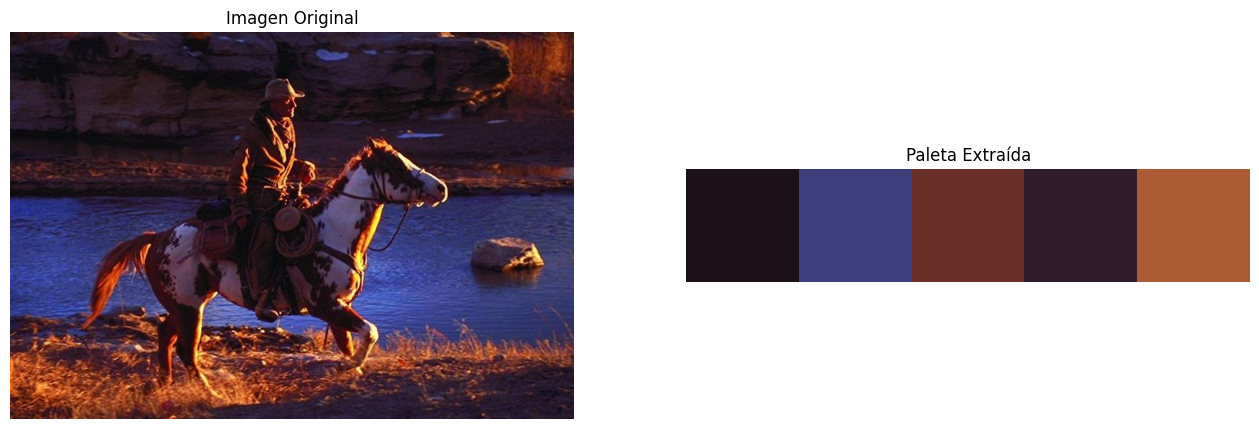

In [46]:
# @title 3. Parámetros y Carga de Imagen de Ejemplo
# -----------------------------------------------------------------------------
# 3. Parámetros y Carga de Imagen de Ejemplo
#    Ahora puedes cargar tu imagen desde Google Drive.
# -----------------------------------------------------------------------------

# @markdown ### Configuración de la Paleta:
NUM_COLORES_PARA_VISUALIZAR = 5 # @param {type:"integer"}
REESCALAR_FACTOR_COLAB = 0.1 # @param {type:"number"}
TOLERANCIA_UNICOS_COLAB = 0.05 # @param {type:"number"}

# @markdown ### Origen de la Imagen:
# @markdown **Selecciona 'Google Drive' si tu imagen está allí.**
# @markdown Si seleccionas 'URL o Subir a Colab', el campo de URL/Path seguirá funcionando como antes.
ORIGEN_IMAGEN = 'Google Drive' # @param ["Google Drive", "URL o Subir a Colab"]

# @markdown **Si tu imagen está en Google Drive, especifica su ruta completa dentro de tu Drive (ej. '/content/drive/MyDrive/Mis_Imagenes/mi_imagen.jpg')**
# @markdown **Si usas 'URL o Subir a Colab', pega la URL o el nombre del archivo subido.**
RUTA_IMAGEN = '/content/drive/MyDrive/FINAL_COLOR EN BLENDER/Image_ejemplo/hidalgo.jpg' # @param {type:"string"}
IMAGEN_URL_O_PATH = RUTA_IMAGEN # Se usa para compatibilidad con la función existente

# Montar Google Drive si se seleccionó esa opción
if ORIGEN_IMAGEN == 'Google Drive':
    from google.colab import drive
    print("Montando Google Drive...")
    drive.mount('/content/drive')
    print("Google Drive montado. Asegúrate de que la ruta de la imagen sea correcta.")
    # Ahora la IMAGEN_URL_O_PATH ya tiene la ruta del Drive
else:
    # Si no es de Drive, seguimos usando el campo RUTA_IMAGEN como URL o path local
    # No se necesita montar Drive en este caso
    pass


# Ejecutar la extracción de paleta
colores_paleta, pixeles_normalizados, kmeans_model = extraer_paleta_de_imagen_colab(
    IMAGEN_URL_O_PATH,
    num_colores=NUM_COLORES_PARA_VISUALIZAR,
    reescalar_factor=REESCALAR_FACTOR_COLAB,
    tolerancia_unicos=TOLERANCIA_UNICOS_COLAB
)

if colores_paleta is not None:
    print(f"Se extrajeron {len(colores_paleta)} colores únicos.")
    print("Colores de la paleta (RGB normalizado):")
    for i, color in enumerate(colores_paleta):
        print(f"  Color {i+1}: {color}")

    # Mostrar la imagen original
    try:
        original_img = load_image_for_colab(IMAGEN_URL_O_PATH)
        plt.figure(figsize=(16, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title("Imagen Original")
        plt.axis('off')

        # Mostrar la paleta de colores
        plt.subplot(1, 2, 2)
        plt.imshow([colores_paleta]) # Crea una fila de píxeles con los colores
        plt.title("Paleta Extraída")
        plt.axis('off')
        plt.show()

    except Exception as e:
        print(f"No se pudo mostrar la imagen original o la paleta: {e}")
else:
    print("No se pudo extraer la paleta de la imagen.")

# 4. Visualización 3D de los Clusters y Centroides

Cada píxel es un punto en este espacio, y el código los dibuja de forma dispersa. Lo más importante es que también muestra los "centroides" de K-Means (los colores principales de tu paleta) como puntos grandes y destacados. Esto te permite ver cómo el algoritmo de K-Means agrupó los colores similares de la imagen y dónde se sitúan los colores dominantes que extrajo.

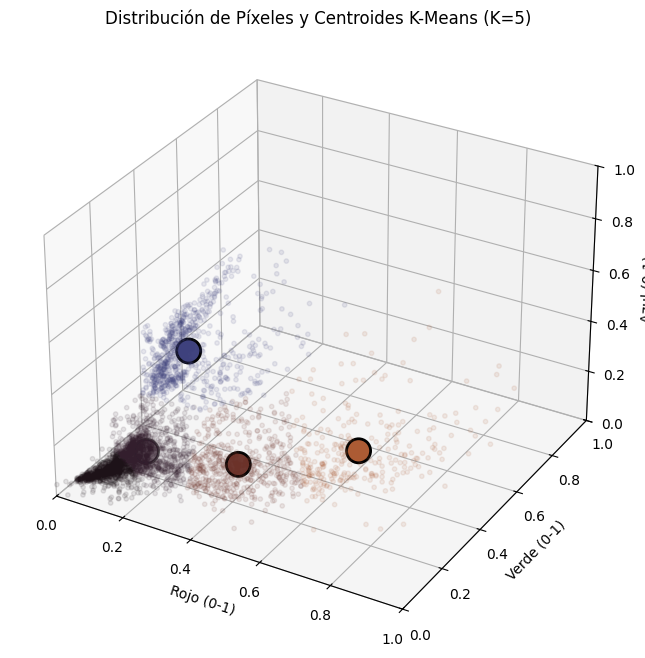

In [47]:
# @title 4. Visualización 3D de los Clusters y Centroides
# -----------------------------------------------------------------------------
# 4. Visualización 3D de los Clusters y Centroides
#    Muestra los píxeles de la imagen como puntos en un espacio 3D (RGB)
#    y los centroides de K-Means como puntos más grandes.
#    Esto visualiza la "nube de puntos" que K-Means está agrupando.
# -----------------------------------------------------------------------------

if pixeles_normalizados is not None and kmeans_model is not None:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Etiquetar cada píxel con el cluster al que pertenece
    labels = kmeans_model.predict(pixeles_normalizados * 255) # Las etiquetas se basan en los datos 0-255

    # Visualizar los píxeles (subconjunto para no saturar)
    # Tomamos una muestra aleatoria de píxeles para mejorar el rendimiento de la visualización
    sample_indices = np.random.choice(len(pixeles_normalizados), min(50000, len(pixeles_normalizados)), replace=False)
    sampled_pixels = pixeles_normalizados[sample_indices]
    sampled_labels = labels[sample_indices]

    # Usamos los colores reales de los píxeles para los puntos, o el color de su cluster
    # Para ver la distribución, es mejor colorear por el color del CLUSTER asignado
    cluster_colors_normalized = kmeans_model.cluster_centers_ / 255.0
    for i in range(len(kmeans_model.cluster_centers_)):
        cluster_pixels = sampled_pixels[sampled_labels == i]
        ax.scatter(cluster_pixels[:, 0], cluster_pixels[:, 1], cluster_pixels[:, 2],
                   c=[cluster_colors_normalized[i]], s=10, alpha=0.1, label=f'Cluster {i+1}')

    # Visualizar los centroides (colores de la paleta)
    centroids_normalized = kmeans_model.cluster_centers_ / 255.0
    ax.scatter(centroids_normalized[:, 0], centroids_normalized[:, 1], centroids_normalized[:, 2],
               marker='o', s=300, c=colores_paleta, edgecolors='black', linewidths=2, label='Centroides')


    ax.set_xlabel('Rojo (0-1)')
    ax.set_ylabel('Verde (0-1)')
    ax.set_zlabel('Azul (0-1)')
    ax.set_title(f'Distribución de Píxeles y Centroides K-Means (K={NUM_COLORES_PARA_VISUALIZAR})')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_zlim(0, 1)
    # ax.legend() # Desactivado para evitar sobrecarga visual con muchos puntos
    plt.show()
else:
    print("Datos de píxeles o modelo K-Means no disponibles para visualización 3D.")

# 5. Animación del Proceso de Actualización de Centroides (Con K-Means custom)

Como la versión estándar de K-Means en scikit-learn no muestra estos pasos intermedios, se implementa una versión simplificada de K-Means que registra la posición de los centroides en cada iteración. Para mantener la claridad y el rendimiento, la animación se proyecta en dos dimensiones (Rojo vs. Verde), mostrando cómo los píxeles se agrupan alrededor de los centroides y cómo estos últimos se mueven y se asientan iterativamente hasta encontrar sus posiciones finales. La animación te permite ver el proceso de aprendizaje no supervisado en acción, ilustrando cómo los colores "convergen" para formar la paleta final.

In [48]:
# @title 5. Animación del Proceso de Actualización de Centroides (Con K-Means custom)
# -----------------------------------------------------------------------------
# 5. Animación del Proceso de Actualización de Centroides
#    Para visualizar esto, necesitamos crear una implementación simplificada de K-Means
#    que guarde el estado de los centroides en cada iteración.
#    K-Means de Scikit-learn no expone fácilmente los estados intermedios.
#    Solo visualizaremos una proyección 2D (ej. Rojo vs Verde) para mayor claridad.
# -----------------------------------------------------------------------------

if pixeles_normalizados is not None:
    print("Creando animación del proceso de K-Means. Esto puede tomar unos segundos.")

    # Implementación simplificada de K-Means para rastrear centroides
    def custom_kmeans_animation(data, k, max_iters=10, random_state=0):
        np.random.seed(random_state)
        # Inicialización de centroides (aleatoria de los datos)
        idx = np.random.choice(len(data), k, replace=False)
        centroids = data[idx]
        centroids_history = [centroids.copy()]

        for i in range(max_iters):
            # Asignación de clústeres
            distances = np.linalg.norm(data[:, np.newaxis] - centroids, axis=2)
            labels = np.argmin(distances, axis=1)

            # Actualización de centroides
            new_centroids = np.array([data[labels == j].mean(axis=0) if np.any(labels == j) else centroids[j]
                                      for j in range(k)])
            centroids = new_centroids
            centroids_history.append(centroids.copy())

            # Criterio de parada (opcional, para esta demo siempre iteramos max_iters)
            # if np.allclose(centroids_history[-2], centroids_history[-1]):
            #     break
        return centroids_history, labels

    # Usaremos solo las dos primeras dimensiones (Rojo y Verde) para una visualización 2D clara
    data_2d = pixeles_normalizados[:, :2]
    # Tomar una muestra de los píxeles para que la animación no sea demasiado pesada
    sample_indices_anim = np.random.choice(len(data_2d), min(10000, len(data_2d)), replace=False)
    sampled_data_2d = data_2d[sample_indices_anim]

    history, final_labels = custom_kmeans_animation(sampled_data_2d, NUM_COLORES_PARA_VISUALIZAR)

    fig_anim, ax_anim = plt.subplots(figsize=(8, 8))
    # Para las fronteras de decisión, podríamos pintar el fondo basado en los centroides.
    # Esto es más fácil con `plt.contourf` y un grid.

    x_min, x_max = sampled_data_2d[:, 0].min() - .1, sampled_data_2d[:, 0].max() + .1
    y_min, y_max = sampled_data_2d[:, 1].min() - .1, sampled_data_2d[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))

    def animate(i):
        ax_anim.clear()
        current_centroids = history[i]

        # Calcular fronteras de decisión (aproximado, usando un clasificador dummy)
        # Para cada punto en el grid, asignarlo al centroide más cercano
        Z_data = np.c_[xx.ravel(), yy.ravel()]
        distances_to_centroids = np.linalg.norm(Z_data[:, np.newaxis] - current_centroids, axis=2)
        Z = np.argmin(distances_to_centroids, axis=1)
        Z = Z.reshape(xx.shape)

        # Usar colores de la paleta (normalizados) para las fronteras
        # Aseguramos que cluster_colors_norm esté definido (es de la celda anterior o lo calculamos aquí)
        if 'cluster_colors_normalized' not in globals() or len(cluster_colors_normalized) != NUM_COLORES_PARA_VISUALIZAR:
             # Si no está disponible del K-Means de sklearn, usamos colores random o del historial
            dummy_colors = plt.cm.get_cmap('viridis', NUM_COLORES_PARA_VISUALIZAR)
            contour_colors = [dummy_colors(j)[:3] for j in range(NUM_COLORES_PARA_VISUALIZAR)]
        else:
            contour_colors = cluster_colors_normalized[:NUM_COLORES_PARA_VISUALIZAR]


        # Dibujar fronteras de decisión
        ax_anim.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('viridis', NUM_COLORES_PARA_VISUALIZAR), alpha=0.4)
        # Puedes usar sns.color_palette para obtener una paleta de colores si viridis no es del agrado
        # sns.color_palette("viridis", NUM_COLORES_PARA_VISUALIZAR)


        ax_anim.scatter(sampled_data_2d[:, 0], sampled_data_2d[:, 1], c='gray', s=10, alpha=0.3, label='Píxeles')
        ax_anim.scatter(current_centroids[:, 0], current_centroids[:, 1], marker='o', s=200, color='red', edgecolors='black', label='Centroides') # Color rojo para destacar movimiento

        ax_anim.set_title(f'Iteración {i+1} de K-Means (R vs G)')
        ax_anim.set_xlabel('Rojo')
        ax_anim.set_ylabel('Verde')
        ax_anim.set_xlim(x_min, x_max)
        ax_anim.set_ylim(y_min, y_max)

    anim = FuncAnimation(fig_anim, animate, frames=len(history), interval=700, repeat=False)
    plt.close(fig_anim) # Evitar mostrar la figura estática

    # Mostrar la animación
    HTML(anim.to_jshtml())
else:
    print("Datos de píxeles no disponibles para la animación de centroides.")

Creando animación del proceso de K-Means. Esto puede tomar unos segundos.


/tmp/ipython-input-48-4168470899.py:76: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ax_anim.contourf(xx, yy, Z, cmap=plt.cm.get_cmap('viridis', NUM_COLORES_PARA_VISUALIZAR), alpha=0.4)


# 6. Cálculo y Visualización del Número Óptimo de Clusters (Silhouette Score)

Esta parte del código evalúa la calidad del agrupamiento de colores (clustering) para diferentes números de clústeres (K). Lo hace calculando el Silhouette Score para un rango de valores de K. Este score mide qué tan bien están definidos los clústeres: un valor más cercano a 1 significa que los colores están bien agrupados y claramente separados de otros grupos de colores. El código entrena un modelo K-Means para cada K en el rango, calcula su score, y luego visualiza estos scores en un gráfico, permitiéndote identificar el número óptimo de colores para tu paleta, que suele ser aquel con el Silhouette Score promedio más alto.

Calculando Silhouette Scores para diferentes números de clústeres.


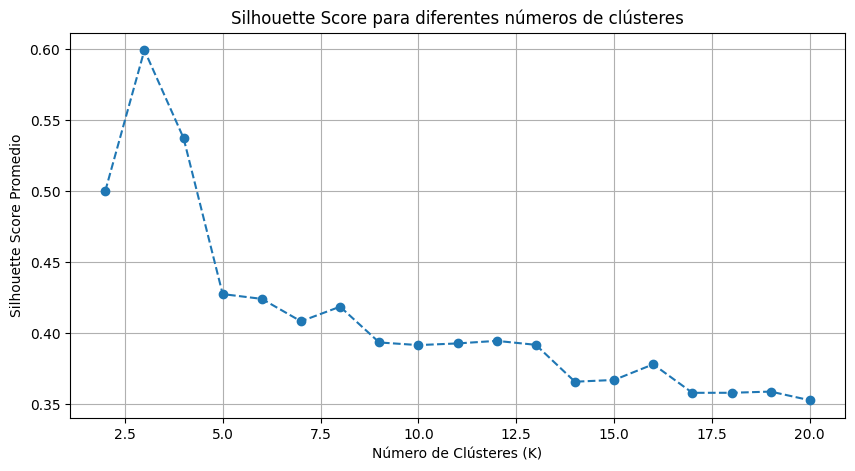

El número óptimo de clústeres sugerido por Silhouette Score es: 3
(Un valor más alto de Silhouette Score indica mejor separación de clústeres)


In [49]:
# @title 6. Cálculo y Visualización del Número Óptimo de Clusters (Silhouette Score)
# -----------------------------------------------------------------------------
# 6. Cálculo y Visualización del Número Óptimo de Clusters (Silhouette Score)
#    El Silhouette Score ayuda a evaluar qué tan bien están separados los clusters.
#    Un valor cercano a 1 indica clusters bien separados.
# -----------------------------------------------------------------------------

if pixeles_normalizados is not None:
    print("Calculando Silhouette Scores para diferentes números de clústeres.")
    range_n_clusters = list(range(2, min(20, len(pixeles_normalizados)//100) + 1)) # De 2 a un máximo razonable

    silhouette_avg_scores = []
    for n_clusters in range_n_clusters:
        try:
            # Necesitamos los datos originales (0-255) para el K-Means de scikit-learn
            # y los píxeles normalizados para el score (aunque K-Means de sklearn acepta ambos)
            kmeans_test = KMeans(n_clusters=n_clusters, random_state=0, n_init='auto')
            cluster_labels = kmeans_test.fit_predict(pixeles_normalizados * 255)
            # El silhouette_score se calcula mejor con los datos originales (no con los normalizados si se usó 0-255 en kmeans)
            # o ambos normalizados. Aquí usaremos los datos normalizados para la coherencia visual.
            silhouette_avg = silhouette_score(pixeles_normalizados, cluster_labels)
            silhouette_avg_scores.append(silhouette_avg)
        except ValueError as e:
            print(f"No se pudo calcular Silhouette Score para {n_clusters} clusters: {e}")
            silhouette_avg_scores.append(0) # O np.nan para no afectar el max

    plt.figure(figsize=(10, 5))
    plt.plot(range_n_clusters, silhouette_avg_scores, marker='o', linestyle='--')
    plt.title('Silhouette Score para diferentes números de clústeres')
    plt.xlabel('Número de Clústeres (K)')
    plt.ylabel('Silhouette Score Promedio')
    plt.grid(True)
    plt.show()

    if silhouette_avg_scores:
        optimal_k_index = np.argmax(silhouette_avg_scores)
        optimal_k = range_n_clusters[optimal_k_index]
        print(f"El número óptimo de clústeres sugerido por Silhouette Score es: {optimal_k}")
        print(f"(Un valor más alto de Silhouette Score indica mejor separación de clústeres)")
else:
    print("Datos de píxeles no disponibles para el cálculo del Silhouette Score.")

# 7. Diagramas de Siluetas para Múltiples Valores de K

Esta parte del código genera y muestra múltiples diagramas de siluetas para un rango de valores de K (número de colores). Para cada K, entrena un modelo K-Means y calcula cómo de bien se agrupan los píxeles en sus respectivos clústeres. Al final, presenta un análisis que compara los "Silhouette Scores" promedio de cada K, sugiere el valor de K más óptimo y ofrece una interpretación clara sobre la compactación y separación de los clústeres, indicando si los colores extraídos son bien distintos o si hay superposición.

Generando diagramas de siluetas para K desde 2 hasta 7.


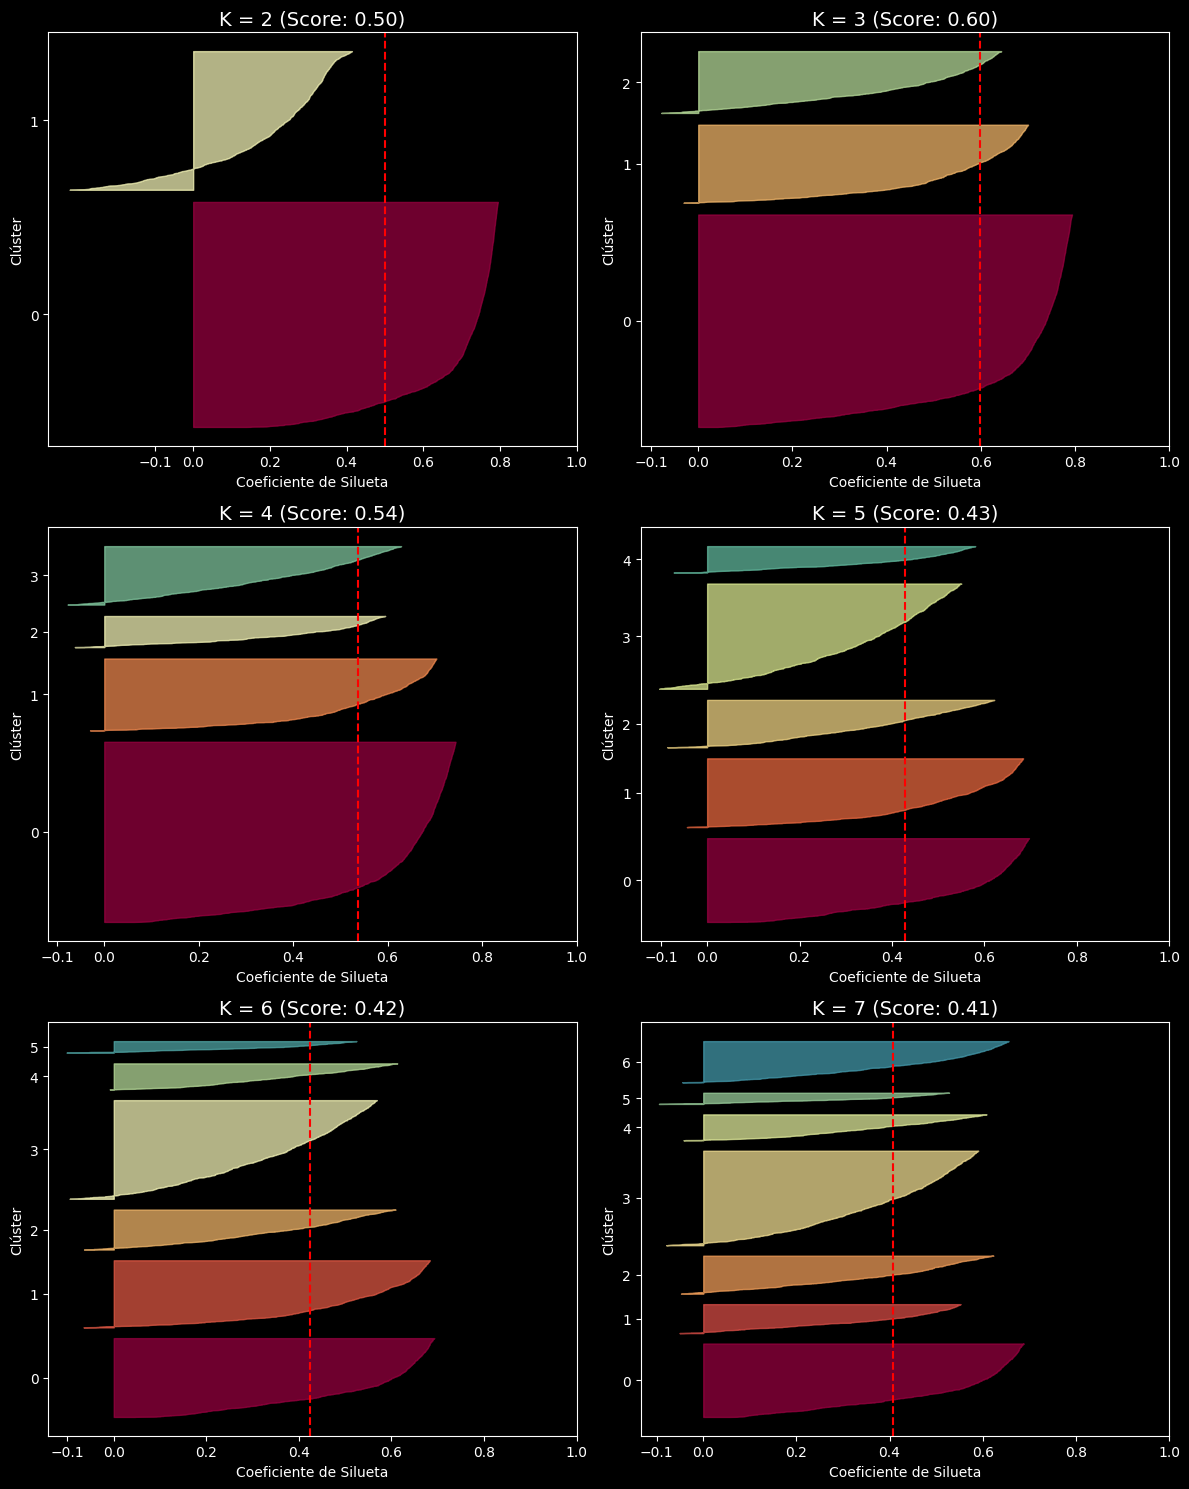

--- Análisis de la Calidad de los Clústeres ---
Para K=2, el Coeficiente de Silueta promedio es: 0.500
Para K=3, el Coeficiente de Silueta promedio es: 0.599
Para K=4, el Coeficiente de Silueta promedio es: 0.537
Para K=5, el Coeficiente de Silueta promedio es: 0.427
Para K=6, el Coeficiente de Silueta promedio es: 0.424
Para K=7, el Coeficiente de Silueta promedio es: 0.408

El valor de K con el Silhouette Score promedio más alto es K=3 (Score: 0.599).
Los clústeres están razonablemente bien separados, pero podría haber cierta **superposición**.


In [60]:
# @title 7. Diagramas de Siluetas para Múltiples Valores de K
# -----------------------------------------------------------------------------
# 7. Diagramas de Siluetas para Múltiples Valores de K (Comparativa)
#    Muestra la calidad de la asignación para un rango de valores de K.
# -----------------------------------------------------------------------------

from sklearn.metrics import silhouette_samples, silhouette_score
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

# Asegúrate de que pixeles_normalizados esté disponible desde la ejecución de la Celda 3.
# Si no, esta celda dará un error.
# Normalmente, después de ejecutar e interactuar con la celda 3,
# 'pixeles_normalizados' debería estar en el entorno global.

# Rango de K a visualizar
k_start = 2 # K mínimo para el análisis de siluetas
k_end = 7   # K máximo para el análisis de siluetas

if 'pixeles_normalizados' in locals() and pixeles_normalizados is not None and len(pixeles_normalizados) > 0:
    print(f"Generando diagramas de siluetas para K desde {k_start} hasta {k_end}.")

    # Listas para almacenar los modelos K-Means y los scores de silueta
    kmeans_models_for_k_range = {}
    silhouette_scores_for_k_range = {} # Para almacenar los scores promedio

    # Entrenar K-Means para cada K en el rango y calcular los scores
    for k in range(k_start, k_end + 1):
        kmeans_current_k = KMeans(n_clusters=k, random_state=0, n_init='auto')
        # Entrenar con datos 0-255 si `pixeles_normalizados` es 0-1
        cluster_labels_k = kmeans_current_k.fit_predict(pixeles_normalizados * 255)
        kmeans_models_for_k_range[k] = kmeans_current_k

        # Calcular el Silhouette Score promedio para este K (con datos normalizados 0-1)
        score_k = silhouette_score(pixeles_normalizados, cluster_labels_k)
        silhouette_scores_for_k_range[k] = score_k

    # Preparar el gráfico de subplots
    num_plots = k_end - k_start + 1
    num_cols = 2 if num_plots > 1 else 1
    num_rows = (num_plots + num_cols - 1) // num_cols # Redondeo hacia arriba

    plt.figure(figsize=(12, 5 * num_rows), facecolor='black') # Ajusta el tamaño de la figura principal

    for plot_idx, k in enumerate(range(k_start, k_end + 1)):
        plt.subplot(num_rows, num_cols, plot_idx + 1) # Crear un subplot para cada K

        kmeans_current_k = kmeans_models_for_k_range[k]
        cluster_labels_k = kmeans_current_k.labels_ # Las etiquetas del modelo ya entrenado

        # Calcular los coeficientes de silueta para cada punto
        silhouette_coefficients = silhouette_samples(pixeles_normalizados, cluster_labels_k)

        padding = len(pixeles_normalizados) // 30 # Espacio entre clusters en el gráfico
        pos = padding
        ticks = [] # Posiciones de los ticks para las etiquetas de los clusters

        for i in range(k): # Iterar sobre cada cluster
            coeffs = silhouette_coefficients[cluster_labels_k == i]
            coeffs.sort() # Ordenar los coeficientes para la visualización de siluetas

            color = mpl.colormaps['Spectral'](i / k) # Asignar un color distinto a cada cluster

            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7) # Rellenar la silueta
            ticks.append(pos + len(coeffs) // 2) # Guardar la posición para la etiqueta del cluster
            pos += len(coeffs) + padding # Mover la posición para el siguiente cluster

        plt.gca().yaxis.set_major_locator(FixedLocator(ticks)) # Posicionar las etiquetas de los clusters
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k))) # Formatear las etiquetas
        plt.ylabel("Clúster", color='white') # Etiqueta del eje Y

        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1]) # Establecer ticks del eje X
        plt.xlabel("Coeficiente de Silueta", color='white') # Etiqueta del eje X

        # Línea punteada roja para el Silhouette Score promedio de este K
        if k in silhouette_scores_for_k_range:
            plt.axvline(x=silhouette_scores_for_k_range[k], color="red", linestyle="--")
            plt.title(f"K = {k} (Score: {silhouette_scores_for_k_range[k]:.2f})", fontsize=14, color='white')
        else:
            plt.title(f"K = {k}", fontsize=14, color='white')

        # Ajustar colores de los ejes y ticks para fondo oscuro
        plt.gca().tick_params(axis='x', colors='white')
        plt.gca().tick_params(axis='y', colors='white')
        plt.gca().spines['bottom'].set_color('white')
        plt.gca().spines['left'].set_color('white')
        plt.gca().spines['top'].set_color('white')
        plt.gca().spines['right'].set_color('white')
        plt.gca().set_facecolor('black') # Fondo del área del gráfico

    plt.tight_layout() # Ajustar el diseño para evitar superposiciones
    plt.show()

    # ---
    ### Análisis de la Calidad de los Clústeres

    print("--- Análisis de la Calidad de los Clústeres ---")
    best_k = None
    best_score = -1

    for k, score in silhouette_scores_for_k_range.items():
        print(f"Para K={k}, el Coeficiente de Silueta promedio es: {score:.3f}")
        if score > best_score:
            best_score = score
            best_k = k

    print(f"\nEl valor de K con el Silhouette Score promedio más alto es K={best_k} (Score: {best_score:.3f}).")

    if best_score > 0.7:
        print("Esto sugiere que los clústeres son bastante **compactos y bien separados**.")
    elif best_score > 0.5:
        print("Los clústeres están razonablemente bien separados, pero podría haber cierta **superposición**.")
    elif best_score > 0.3:
        print("La separación de los clústeres es **débil**, indicando posible superposición o mala asignación.")
    else:
        print("Los clústeres **no están bien separados** y/o hay muchos puntos asignados incorrectamente.")


else:
    print("Datos de píxeles (pixeles_normalizados) no disponibles. Asegúrate de ejecutar la celda 3 y seleccionar una imagen.")